In [2]:
import argparse
import os
import sys
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
def load_data(path):
    df = pd.read_csv(path)   # <-- missing line
    expected_cols = set(['N','P','K','temperature','humidity','ph','rainfall','label'])
    if expected_cols.issubset(set(df.columns)):
        return df
    # try to be flexible: lowercase cols
    cols_lower = [c.lower() for c in df.columns]
    colmap = {c.lower(): c for c in df.columns}
    if expected_cols.issubset(set(cols_lower)):
        df = df.rename(columns={colmap[c]: c for c in cols_lower if c in expected_cols})
    return df
    # last resort: attempt to infer columns by names
    candidates = {k: None for k in expected_cols}
    for c in df.columns:
        lc = c.lower()
        if 'nitro' in lc or lc == 'n':
            candidates['N'] = c
        if 'phosph' in lc or lc == 'p':
            candidates['P'] = c
        if lc == 'k' or 'potass' in lc:
            candidates['K'] = c
        if 'temp' in lc:
            candidates['temperature'] = c
        if 'humid' in lc:
            candidates['humidity'] = c
        if 'ph' == lc or lc == 'ph':
            candidates['ph'] = c
        if 'rain' in lc:
            candidates['rainfall'] = c
        if 'label' in lc or 'crop' in lc:
            candidates['label'] = c
    if any(v is None for v in candidates.values()):
        raise ValueError('Dataset columns could not be mapped to expected features. Found: ' + ','.join(df.columns))
    df = df.rename(columns={v: k for k, v in candidates.items()})
    return df

In [4]:
def build_and_train(df, save_dir='model_artifacts'):
    X = df[['N','P','K','temperature','humidity','ph','rainfall']].values
    y = df['label'].values

    # Encode labels
    le = LabelEncoder()
    y_enc = le.fit_transform(y)


    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)


    # Pipeline: scaler + classifier
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
    ])


    # Basic hyperparam grid
    param_grid = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [10, 20, None],
        'clf__min_samples_split': [2, 5]
    }


    grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)


    print('\nBest params:', grid.best_params_)


    # Eval
    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}\n")
    print('Classification Report:\n')
    print(classification_report(y_test, y_pred, target_names=le.classes_))


    # Save artifacts
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, 'crop_recommendation_model.pkl')
    le_path = os.path.join(save_dir, 'label_encoder.pkl')
    joblib.dump(grid.best_estimator_, model_path)
    joblib.dump(le, le_path)
    print(f"Saved model to: {model_path}\nSaved label encoder to: {le_path}")


    return grid.best_estimator_, le



In [5]:
def load_model(model_path, le_path):
    model = joblib.load(model_path)
    le = joblib.load(le_path)
    return model, le

In [6]:
def predict_sample(model, le, sample_dict):
    # sample_dict: {'N':xx,'P':xx,'K':xx,'temperature':xx,'humidity':xx,'ph':xx,'rainfall':xx}
    order = ['N','P','K','temperature','humidity','ph','rainfall']
    x = np.array([[sample_dict[k] for k in order]], dtype=float)
    pred_idx = model.predict(x)[0]
    pred_label = le.inverse_transform([pred_idx])[0]
    return pred_label

In [7]:
import sys

parser = argparse.ArgumentParser(description='Train crop recommendation model')
parser.add_argument('--data', type=str, help='path to CSV dataset')
parser.add_argument('--save-dir', type=str, default='model_artifacts', help='where to save model')
args, unknown = parser.parse_known_args()   # <-- ignore Jupyter's extra args



data_file = 'Crop_recommendation.csv'
print('Loading data from', data_file)
df = load_data(data_file)
print('Dataset shape:', df.shape)
model, le = build_and_train(df, save_dir=args.save_dir)


# example prediction
sample = {
    'N': 90,
    'P': 42,
    'K': 43,
    'temperature': 20.9,
    'humidity': 82.0,
    'ph': 6.5,
    'rainfall': 202.9354
}
pred = predict_sample(model, le, sample)
print('Example sample predicted crop:', pred)

Loading data from Crop_recommendation.csv
Dataset shape: (2200, 8)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Test Accuracy: 0.9932

Classification Report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate model
y_pred = model.predict(df[['N','P','K','temperature','humidity','ph','rainfall']].values)

print("Accuracy:", accuracy_score(le.transform(df['label']), y_pred))
print("\nClassification Report:\n")
print(classification_report(le.transform(df['label']), y_pred, target_names=le.classes_))

Accuracy: 0.9963636363636363

Classification Report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00       100
      banana       1.00      1.00      1.00       100
   blackgram       1.00      0.99      0.99       100
    chickpea       1.00      1.00      1.00       100
     coconut       1.00      1.00      1.00       100
      coffee       1.00      1.00      1.00       100
      cotton       1.00      1.00      1.00       100
      grapes       1.00      1.00      1.00       100
        jute       0.94      1.00      0.97       100
 kidneybeans       1.00      1.00      1.00       100
      lentil       1.00      0.99      0.99       100
       maize       0.99      1.00      1.00       100
       mango       1.00      1.00      1.00       100
   mothbeans       0.99      1.00      1.00       100
    mungbean       1.00      1.00      1.00       100
   muskmelon       1.00      1.00      1.00       100
      orange       1.00    

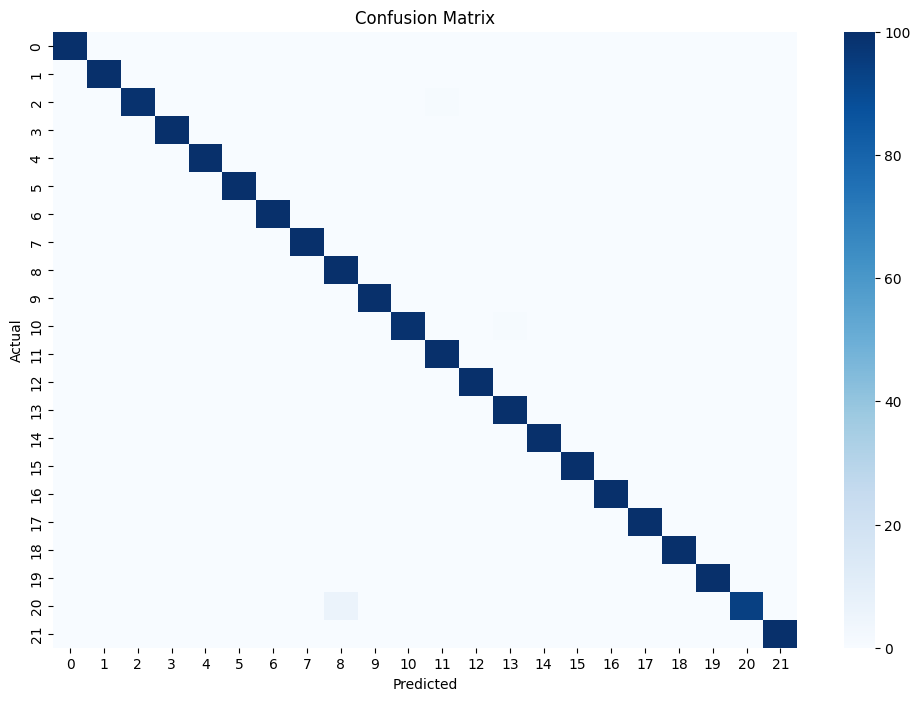

In [11]:
import matplotlib.pyplot as plt;
import seaborn as sns;

# Confusion matrix heatmap
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(le.transform(df['label']), y_pred), cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()